# Preprocesamiento del Dataset y Selección de Variables

Este notebook tienen como objetivo la fase de "ingeniería" donde transformamos los **datos crudos** (los que obtuvimos en el EDA) en el combustible limpio y de alto octanaje que usaremos para entrenar nuestros modelos.

Basado en nuestros hallazgos en la fase anterior (outliers, gaps, MNAR, correlaciones), tomarmos decicisones que nos lleven a alcanzar ese objetivo.

# Fase A: Preparación de Datos Base

## 1. Carga de Datos

In [37]:
# Seteo inicial

import sys
import logging
import warnings
from pathlib import Path

# Configuración de logging y advertencias
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
warnings.filterwarnings('ignore')


# Configuración de Paths
BASE_DIR = Path('../').resolve()
DATA_DIR = BASE_DIR / 'data'
SRC_DIR = BASE_DIR / 'src'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
sys.path.append(str(SRC_DIR))

logging.info(f"Directorio Base: {BASE_DIR}")
logging.info(f"Directorio de Datos: {DATA_DIR}")
logging.info(f"Directorio Procesado: {PROCESSED_DIR}")
logging.info(f"Directorio Src: {SRC_DIR}")

2025-11-15 19:31:31,962 - Directorio Base: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF
2025-11-15 19:31:31,963 - Directorio de Datos: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/data
2025-11-15 19:31:31,964 - Directorio Procesado: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/data/processed
2025-11-15 19:31:31,965 - Directorio Src: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/src


### Cargar el Dataset Base

In [38]:
import pandas as pd

df = pd.read_csv(PROCESSED_DIR / 'dataset_v01.csv', parse_dates=['Fecha'], index_col='Fecha')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1190 entries, 2020-07-01 23:59:00 to 2023-10-26 07:00:00
Columns: 149 entries, Planta (Kw) to Totalizador_Filtracion
dtypes: float64(145), int64(4)
memory usage: 1.4 MB


---

## 2. Limpieza y Acondicionamiento de fechas.

### Limpieza de Rango de Fechas

Como vimos durante el EDA, algunas de nuestras fechas faltan o estan incompletas (no llegan hasta las 23:59). En este apartado vamos a tratar esas filas para dejarlas en condiciones antes del preporcesado.

In [39]:
# Ejemplo de fila incompleta
df.last_valid_index()

Timestamp('2023-10-26 07:00:00')

En este caso, como `2023-10-26` es la última fila lo más sencillo es eliminarla. Esto ya que no provoca una pérdida de continuidad y tenemos datos suficientes como para permitirnoslo.

In [40]:
df = df.loc[df.index < '2023-10-26']

# Nuestra fecha máxima de datos ahora es 2023-10-25
df.last_valid_index()

Timestamp('2023-10-25 23:59:00')

Ahora vamos a buscar las fechas con horas distintas a las `23:59:00` y decidiremos si las eliminamos (considerándolas como día faltantes) o si las conservamos como están.

In [41]:
import numpy as np

# Verificar si hay fechas con horas distintas a 23:59:00

# Extraer la hora de cada índice
df_horas = df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S'))

# Identificar las fechas que no terminan en 23:59:00
fechas_incompletas = df[df_horas != '23:59:00']

print(f"Total de fechas con horas distintas a 23:59:00: {len(fechas_incompletas)}")

print("\nFechas incompletas encontradas:")
# Las ordenamos por hora de forma ascendente para facilitar su revisión y solo comparamos la columna 'Frio (Kw)'
fechas_incompletas = fechas_incompletas.assign(hora=df_horas[df_horas != '23:59:00']).sort_values(by='hora')
display(fechas_incompletas['Frio (Kw)'])

Total de fechas con horas distintas a 23:59:00: 19

Fechas incompletas encontradas:


Fecha
2023-04-19 16:00:00    13439.0
2023-04-13 19:00:00    14315.0
2022-03-02 23:00:00    19294.0
2021-07-13 23:00:00    33704.0
2023-02-23 23:59:01    20688.0
2022-12-08 23:59:01    21663.0
2022-04-29 23:59:01    31316.0
2022-04-05 23:59:01    22573.0
2020-08-12 23:59:01    29964.0
2021-04-11 23:59:01    26888.0
2020-12-30 23:59:01    11433.0
2020-10-22 23:59:01    28374.0
2020-10-08 23:59:01    30220.0
2020-08-25 23:59:01    37809.0
2021-08-25 23:59:01    37122.0
2023-07-07 23:59:01    22348.0
2023-06-30 23:59:59    20274.0
2021-06-30 23:59:59    32571.0
2022-06-30 23:59:59    26459.0
Name: Frio (Kw), dtype: float64

Como vemos, la gran mayoría de estas fechas tienen diferencias de **segundos** con la hora que estamos comparando, por lo que vamos a tomarlas como válidas. También lo haremos con las fechas con hora `23:00:00`, siguen aportando información relevante y suficiente para nuestro análisis.

En cambio, aquellos días que poseen horas `< 23:00:00` vamos a eliminarlas y las tomaremos como valores faltantes que trataremos más adelante.

In [42]:
print("Shape previo a filtrado:", df.shape)

df =  df.loc[~((df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S')) < '23:00:00'))]

print("Shape posterior a filtrado:", df.shape)

Shape previo a filtrado: (1189, 149)
Shape posterior a filtrado: (1187, 149)


In [43]:
# Eliminar la hora del índice, dejando solo la fecha
df.index = df.index.normalize()
df.tail()

Planta (Kw)  Elaboracion (Kw)  Bodega (Kw)  Cocina (Kw)  \
Fecha                                                                  
2023-10-21  21627.800000            2383.0       3119.0        242.0   
2023-10-22  30287.570000            3200.0       2788.0       1387.0   
2023-10-23  28667.480000            2329.0       2882.0        313.0   
2023-10-24  31263.160156            3077.0       3405.0        235.0   
2023-10-25  30501.320312            3194.0       3671.0        251.0   

            Envasado (Kw)  Linea 2 (Kw)  Linea 3 (Kw)  Linea 4 (Kw)  \
Fecha                                                                 
2023-10-21          452.0    461.300000         546.0           0.0   
2023-10-22         2758.0   4351.070000         584.0           0.0   
2023-10-23         3339.0   5503.480000         550.0           0.0   
2023-10-24         5513.0   6940.660156        1287.0           0.0   
2023-10-25         4306.0   6812.820312         528.0           0.0   

            Servicios (Kw)  Sala Maq (Kw)  ...  Tot L3. L4 y Planta de CO2  \
Fecha                                      ...                               
2023-10-21         16977.0         9793.0  ...                         NaN   
2023-10-22         20821.0        11873.0  ...                         NaN   
2023-10-23         18771.0        10395.0  ...                         NaN   
2023-10-24         18461.0        10614.0  ...                         NaN   
2023-10-25         18692.0        10809.0  ...                         NaN   

            Tot A40/240/50/60/Centec/Filtro  Tot  A130/330/430  \
Fecha                                                            
2023-10-21                         2194.000           6922.250   
2023-10-22                         2070.875           6019.625   
2023-10-23                         1828.250           6030.000   
2023-10-24                          728.500           6006.000   
2023-10-25                         1191.625           5969.625   

            Tot L3, L4 y Planta de CO2  Totalizador_L2_Barriles  \
Fecha                                                             
2023-10-21                    40.12500                      0.0   
2023-10-22                    72.56250                   1271.0   
2023-10-23                    74.53125                   1323.0   
2023-10-24                    79.78125                   1485.0   
2023-10-25                    54.93750                   1217.0   

            Totalizador_L3  Totaliador_Latas  Totalizador_Bodega  \
Fecha                                                              
2023-10-21             0.0               0.0              0.0000   
2023-10-22             0.0               0.0              7.9375   
2023-10-23             0.0               0.0              0.0000   
2023-10-24             0.0               0.0            952.0625   
2023-10-25             0.0               0.0           1690.5625   

            Totalizador_Tq_Pulmon  Totalizador_Filtracion  
Fecha                                                      
2023-10-21                 1649.0                     0.0  
2023-10-22                 2863.0                     1.0  
2023-10-23                 3244.0                     1.0  
2023-10-24                 4538.0                   737.0  
2023-10-25                 4756.0                  1552.0  

[5 rows x 149 columns]

### Tratado de Gaps y re-index de fechas

En el EDA encontramos que nuestro dataset presentaba inconsistencias en cuanto a la continuidad temporal, nos faltaban algunos días de manera aleatoria y otros no tanto. Vamos a analizar los contextos y solucionar respecto a ellos:

**Análisis de las Opciones**

- **Días 31 Faltantes:**

    - *Opción 1:* Asumir meses de 30 días. 
    En esta opción estaríamos eliminando días reales de consumo (como 31/Ene, 31/Mar, 31/Jul) solo porque algunos 31s fallaron. Esto sesgaría la estacionalidad y perderíamos información valiosa.

    - *Opción 2:* Imputar. 
    Estos parecen ser errores de registro (aleatorios o sistemáticos). La planta operó y consumió energía, pero el dato no se guardó. Deben ser tratados como NaN y ser imputados más tarde.

- **Agosto 29, 30, 31 (Patrón Anual):**
    
    La mejor estrategia sería asumir que estos días la planta tiene consumo cero. Esto probablemente se deba a un *cierre de mantenimiento programado anual* al final del verano.
    
    Imputaremos 0 en esos días para enseñarle a los modelos dos cosas vitales:

    1. Que el consumo en esos días específicos es cero (o cercano a cero).
    
    2. Cómo es el arranque de la planta el 1 de septiembre (el lag_1_Frio será 0, algo que el modelo debe aprender).

In [44]:
# --- Reindexar para exponer los Gaps ---

# Usamos tu rango de fechas corregido

print(f"Forma original: {df.shape}")
# Definir el rango de fechas completo y correcto
full_date_range = pd.date_range(start='2020-07-01', end='2023-10-25', freq='D')

# Re-indexar para crear los 42 días faltantes como filas NaN
# df_full = df.reindex(full_date_range)
# print(f"Forma re-indexada: {df_full.shape}")

#Por ahora no agregamos filas NaN
df_full = df.copy()

Forma original: (1187, 149)


In [45]:
# Partimos de df_full = df.copy()
# Este codigo lo agregamos para poder indexar manualmente los dias 29-30-31 de agosto de los años 2020-2023

# Definimos los años y los días de shutdown
years = [2020, 2021, 2022, 2023]
days = [29, 30, 31]
month = 8  # agosto

# Creamos las fechas de shutdown
shutdown_dates = pd.to_datetime(
    [f"{y}-08-{d:02d}" for y in years for d in days]
)

# Si tu índice tiene horas (datetime completo), normalizamos ambos a fecha
df_full.index = pd.to_datetime(df_full.index).normalize()
shutdown_dates = shutdown_dates.normalize()

# Creamos un nuevo índice que es la unión del actual + los shutdowns
new_index = df_full.index.union(shutdown_dates)

# Reindexamos SOLO a ese índice extendido
df_full = df_full.reindex(new_index)


In [46]:
# --- Imputar manualmente todo con 0 ---

# Usamos .loc[] para asignar el valor en las filas correctas
shutdown_mask = ((df_full.index.month == 8) & 
                 ((df_full.index.day == 29) | (df_full.index.day == 30) | (df_full.index.day == 31))
                )
df_full.loc[shutdown_mask, :] = 0

# Validación
print("Validación de imputación manual (debería ser 0.0):")
print(df_full.loc['2020-08-29']['Frio (Kw)'])
print(df_full.loc['2021-08-30']['Frio (Kw)'])
print(df_full.loc['2022-08-31']['Frio (Kw)'])

Validación de imputación manual (debería ser 0.0):
0.0
0.0
0.0


### Eliminación de columnas sin información

In [47]:
df_full.isna().sum().sort_values(ascending=False).loc[lambda x: x > 0]

Agua Cocina (Hl)                   1186
Agua Elaboracion (Hl)              1186
Agua CO2                           1186
Agua Dilucion (Hl)                 1186
Agua Envasado (Hl)                 1186
Agua Servicios (Hl)                1186
Planta de agua (Hl)                1186
Produccion (Hl)                    1186
Red L1 y L2                        1186
FC L1 y L2                         1186
FC Lavadora L2                     1186
Red L3                             1186
FC Lavadora L3                     1186
Red Paste L4                       1186
FC Barriles                        1186
Agua Paste L3                      1186
Agua Lavadora L3                   1186
Agua Cond Evaporativos             1186
Agua Calderas                      1186
Agua Bodega (Hl)                   1186
Agua Efluentes                     1186
Agua Planta (Hl)                   1186
Tot L3, L4 y Planta de CO2          716
Tot L3. L4 y Planta de CO2          584
Tot Fermantacion_Cocina             574


Columnas eliminadas por tener más del 30% de valores NaN: 29
Forma del dataset después de eliminar columnas sin información: (1198, 120)


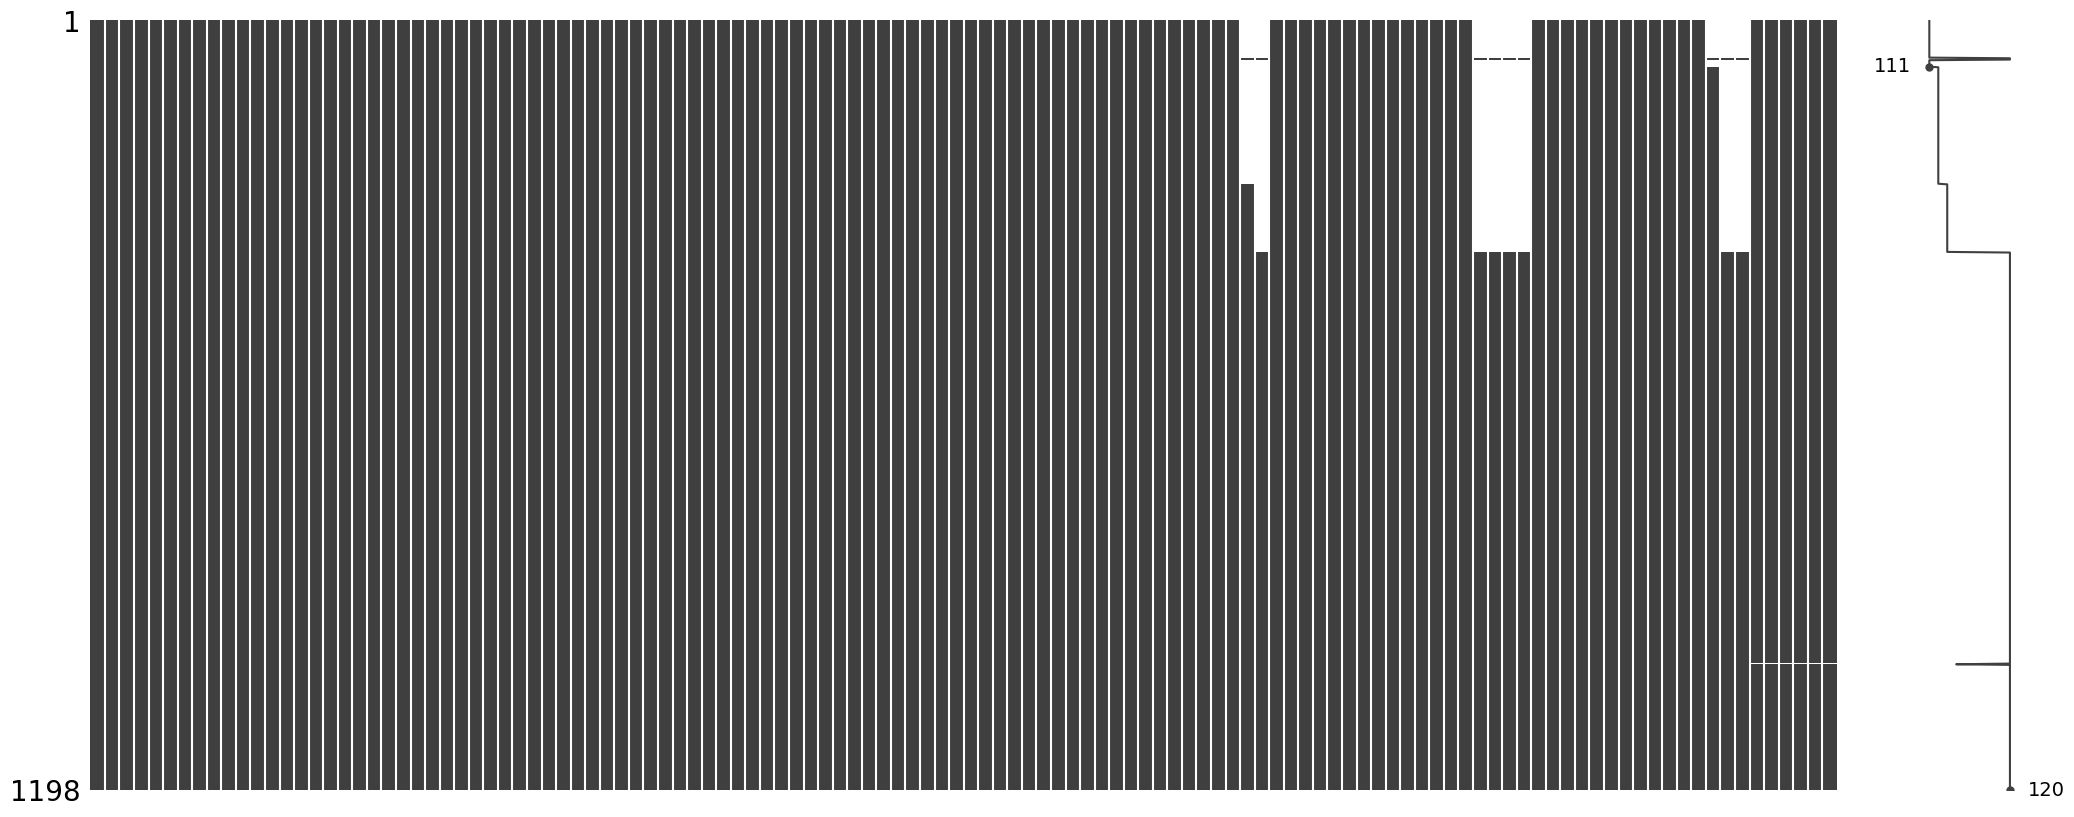

In [48]:
# --- Eliminar columnas sin información ---

# Eliminar columnas con más del 30% de valores NaN
df_full = df_full.loc[:, df_full.isna().mean() < 0.3]

# Tamaño del dataset después de eliminar columnas sin información
print("Columnas eliminadas por tener más del 30% de valores NaN:", df.shape[1] - df_full.shape[1])
print(f"Forma del dataset después de eliminar columnas sin información: {df_full.shape}")
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df_full)
plt.show()

In [49]:
from aux_functions import track_data_artifact

df_full.to_csv(PROCESSED_DIR / 'dataset_v2.csv')

track_data_artifact(
	PROCESSED_DIR / 'dataset_v2.csv',
	'Dataset con fechas normalizadas y gaps expuestos',
	[PROCESSED_DIR / 'dataset_v2.csv'],
	parameters={'description': 'Dataset con fechas normalizadas, gaps expuestos y mantenimientos de agosto imputados a 0'},
	base_dir=BASE_DIR,
	checksums_file_path=DATA_DIR / 'checksums.json',
	lineage_file_path=PROCESSED_DIR / 'data_lineage.json',
)

2025-11-15 19:31:32,262 - --- Iniciando tracking de artefacto para: dataset_v2.csv ---
2025-11-15 19:31:32,263 - Checksum (SHA256): e582342042b48be1d1dd485bb0c9ee69142ecc7098d1be2140e5ee77baf5f97e
2025-11-15 19:31:32,264 - Checksum guardado en checksums.json
2025-11-15 19:31:32,265 - Data lineage actualizado en data_lineage.json
2025-11-15 19:31:32,265 - --- Tracking de artefacto completado ---


---

## 3. Split de Datos

Eliminamos dos días con outliers en la variable objetivo (seguramente podriamos tomar el valor anterior o algo similar, pero por ahora los eliminamos)

In [ ]:
df_full["Frio (Kw)"].sort_values(ascending=False).head(10)

filas_a_eliminar = ["2021-11-28", "2021-04-30"]

df_full = df_full.drop(index=pd.to_datetime(filas_a_eliminar))


2021-08-01    56128.0
2021-07-21    54681.0
2021-06-22    48046.0
2021-07-12    46001.0
2021-04-29    42919.0
2021-08-24    42604.0
2021-06-23    42005.0
2022-06-04    41901.0
2022-07-20    41206.0
2021-06-16    41203.0
Name: Frio (Kw), dtype: float64

In [51]:
# Dividir en train, val y test para busqueda de hiperparámetros del pipeline de preprocesamiento



# Train 70%
train_size = int(len(df_full) * 0.7)
train_df = df_full.iloc[:train_size]

# Validation 10%
val_size = int(len(df_full) * 0.1)
val_df = df_full.iloc[train_size:train_size + val_size]

# Test 20%
test_df = df_full.iloc[train_size + val_size:]

print("Train:")
print(f"- shape: {train_df.shape}")
print(f"- Rango: {train_df.index.min()} to {train_df.index.max()}")

print("\nValidation:")
print(f"- shape: {val_df.shape}")
print(f"- Rango: {val_df.index.min()} to {val_df.index.max()}")

print("\nTest:")
print(f"- shape: {test_df.shape}")
print(f"- Rango: {test_df.index.min()} to {test_df.index.max()}")

Train:
- shape: (837, 120)
- Rango: 2020-07-01 00:00:00 to 2022-10-25 00:00:00

Validation:
- shape: (119, 120)
- Rango: 2022-10-26 00:00:00 to 2023-02-23 00:00:00

Test:
- shape: (240, 120)
- Rango: 2023-02-24 00:00:00 to 2023-10-25 00:00:00


In [52]:
# Guardar el dataset de test en csv para uso posterior
test_df.to_csv(PROCESSED_DIR / 'dataset_test_v2.csv')

Agregamos la columna objetivo para train

In [53]:
# Crear la columna objetivo desplazada en train_df
train_df['target_frio'] = train_df['Frio (Kw)'].shift(-1)

# Eliminar la última fila que queda con NaN en el target
train_df = train_df.iloc[:-1]

# (Opcional) chequeo
print(train_df[['Frio (Kw)', 'target_frio']].tail())


            Frio (Kw)  target_frio
2022-10-20    17036.0      17114.0
2022-10-21    17114.0      16743.0
2022-10-22    16743.0      17942.0
2022-10-23    17942.0      20189.0
2022-10-24    20189.0      22990.0


### Pipeline de preprocesamiento

Vamos a crear transformadores para tratar outliers e imputar valores faltantes. Luego, vamos a juntarlos en un pipeline de preprocesamiento.

**Transformador de outliers** (detectando por LOF)

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class LOFOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="winsorize", std_factor=3):
        """
        method: 'winsorize' o 'clip'
        std_factor: número de desvíos estándar para clipping
        """
        self.method = method
        self.std_factor = std_factor
        self.columns_ = None

    def fit(self, X, y=None):
        # Aseguramos DataFrame
        X = pd.DataFrame(X)
        self.columns_ = X.columns

        # Guardamos también los nombres como hace sklearn
        self.feature_names_in_ = self.columns_

        # Entrenamos LOF solo para detectar outliers (por ahora solo guardamos la máscara)
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
        self.outlier_mask_ = lof.fit_predict(X) == -1

        # Estadísticos por columna
        self.means_ = X.mean()
        self.stds_ = X.std()
        self.p1_ = X.quantile(0.01)
        self.p99_ = X.quantile(0.99)

        return self

    def transform(self, X):
        # Volvemos a DataFrame con mismas columnas
        X = pd.DataFrame(X, columns=self.columns_)

        if self.method == "winsorize":
            # Winsorización p1–p99 por columna
            X = X.clip(lower=self.p1_, upper=self.p99_, axis=1)

        elif self.method == "clip":
            # Clipping por medias ± k*std por columna
            lower = self.means_ - self.std_factor * self.stds_
            upper = self.means_ + self.std_factor * self.stds_
            X = X.clip(lower=lower, upper=upper, axis=1)

        # Devolvemos DataFrame con mismo índice y columnas
        return X


**Transformador de imputación** por KNN, linearRegression y MICE

In [55]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.base import BaseEstimator, TransformerMixin

class ImputationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, method="knn"):
        """
        method: 'knn', 'linear', 'mice'
        """
        self.method = method

    def fit(self, X, y=None):
        # Guardar columnas e índice
        self.columns_ = X.columns
        self.index_ = X.index
        
        # Elegir imputador
        if self.method == "knn":
            self.imputer_ = KNNImputer(n_neighbors=5)

        elif self.method == "linear":
            self.imputer_ = IterativeImputer(
                estimator=LinearRegression(),
                max_iter=20,
                random_state=42
            )

        elif self.method == "mice":
            self.imputer_ = IterativeImputer(
                estimator=BayesianRidge(),
                max_iter=20,
                random_state=42
            )

        # Ajustar imputador (recibe numpy, pero X es DataFrame y funciona igual)
        self.imputer_.fit(X)

        return self

    def transform(self, X):
        # Asegurar que X sea DataFrame con columnas correctas (evita problemas dentro del Pipeline)
        X = pd.DataFrame(X, columns=self.columns_)

        # Imputación
        X_imp = self.imputer_.transform(X)

        # Devolver DataFrame con columnas e índice originales
        return pd.DataFrame(X_imp, columns=self.columns_, index=X.index)


**Pipeline de preprocesamiento** 

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

def build_pipeline(impute_method, outlier_method, std_factor):
    pipe = Pipeline([
        ("imputer", ImputationSelector(method=impute_method)),
        ("outliers", LOFOutlierHandler(method=outlier_method, std_factor=std_factor)),
        ("model", RandomForestRegressor(
            n_estimators = 523,
            max_depth= 28,
            random_state=42
        ))
    ])
    return pipe


**Búsqueda de mejores hiperparámetros del pipeline con optuna**

In [57]:
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

def objective(trial):

    # Hiperparámetros a optimizar
    impute_method = trial.suggest_categorical("imputer", ["knn", "linear", "mice"])
    outlier_method = trial.suggest_categorical("outliers", ["winsorize", "clip"])
    std_factor = trial.suggest_float("std_factor", 2.0, 5.0)

    pipe = build_pipeline(impute_method, outlier_method, std_factor)

    tscv = TimeSeriesSplit(n_splits=4)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_df)):

        X_train = train_df.iloc[train_idx].drop(columns=["target_frio"])
        y_train = train_df.iloc[train_idx]["target_frio"]

        X_val = train_df.iloc[val_idx].drop(columns=["target_frio"])
        y_val = train_df.iloc[val_idx]["target_frio"]

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_val)

        mae = mean_absolute_error(y_val, preds)
        scores.append(mae)

        # Reportar avance al pruner
        trial.report(mae, step=fold)

        # Si el pruner decide cortar, lanzar excepción
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(scores)


# Estudio con pruner 
study = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1)
)

# Agregar 50 después, lo hacemos 10 por ahora para no demorar tanto
study.optimize(objective, n_trials=10)

print(study.best_params)
print("Best MAE:", study.best_value)


[I 2025-11-15 19:31:32,329] A new study created in memory with name: no-name-a142b916-0a2c-4d72-9c85-e1770536c166
[I 2025-11-15 19:33:04,503] Trial 0 finished with value: 3738.0376893053117 and parameters: {'imputer': 'mice', 'outliers': 'clip', 'std_factor': 4.980396129114759}. Best is trial 0 with value: 3738.0376893053117.
[I 2025-11-15 19:33:38,948] Trial 1 finished with value: 3752.073193683723 and parameters: {'imputer': 'linear', 'outliers': 'winsorize', 'std_factor': 2.020131959354091}. Best is trial 0 with value: 3738.0376893053117.
[I 2025-11-15 19:34:13,870] Trial 2 finished with value: 3752.073193683723 and parameters: {'imputer': 'linear', 'outliers': 'winsorize', 'std_factor': 3.1019861852384034}. Best is trial 0 with value: 3738.0376893053117.
[I 2025-11-15 19:34:49,342] Trial 3 finished with value: 3738.8591605372326 and parameters: {'imputer': 'linear', 'outliers': 'clip', 'std_factor': 3.9299371149334337}. Best is trial 0 with value: 3738.0376893053117.
[I 2025-11-15 

{'imputer': 'mice', 'outliers': 'clip', 'std_factor': 4.980396129114759}
Best MAE: 3738.0376893053117


In [58]:
# 1. Mejores hiperparámetros
best_params_preproc = study.best_params
best_imputer = best_params_preproc["imputer"]
best_outliers = best_params_preproc["outliers"]
best_std_factor = best_params_preproc["std_factor"]

# 2. Pipeline SOLO de preprocesamiento (sin modelo)

best_pipe_preprocess = Pipeline([
    ("imputer", ImputationSelector(method=best_imputer)),
    ("outliers", LOFOutlierHandler(method=best_outliers, std_factor=best_std_factor)),
])


X_train = train_df.drop(columns=["target_frio"])
y_train = train_df["target_frio"]

# fit + transform en un paso
x_train_processed = best_pipe_preprocess.fit_transform(X_train)



## Pipeline para crear las features temporales

In [59]:
class TimeSeriesFeatureEngineerIndex(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        target_col="Frio (Kw)",
        lags=(1, 2, 3),
        ma_windows=(3, 7)
    ):
        self.target_col = target_col
        self.lags = lags
        self.ma_windows = ma_windows

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Aseguramos que el índice sea datetime
        X.index = pd.to_datetime(X.index)

        # ------- LAGS de Frio (Kw) -------
        for lag in self.lags:
            col_name = f"{self.target_col}_lag_{lag}"
            X[col_name] = X[self.target_col].shift(lag)

        # ------- Promedios móviles de Frio (Kw) -------
        for window in self.ma_windows:
            col_name = f"{self.target_col}_ma_{window}"
            X[col_name] = (
                X[self.target_col]
                .rolling(window=window, min_periods=1)
                .mean()
            )

        # ------- Features de calendario desde el índice -------
        # 0 = lunes, 6 = domingo
        X["day_of_week"] = X.index.dayofweek
        X["month"] = X.index.month
        X["is_weekend"] = X["day_of_week"].isin([5, 6]).astype(int)

        return X


In [60]:
feature_pipe = Pipeline([
    ("time_features", TimeSeriesFeatureEngineerIndex(
        target_col="Frio (Kw)",
        lags=(1, 2, 3, 24),   
        ma_windows=(3, 7, 14) 
    ))
])


X_train_features = feature_pipe.fit_transform(x_train_processed)

X_train_features.head()

Planta (Kw)  Elaboracion (Kw)  Bodega (Kw)  Cocina (Kw)  \
2020-07-01     27637.27           2027.25      2968.00         98.0   
2020-07-02     54409.81           5391.13      5595.88        928.0   
2020-07-03     65685.59           6437.75      6237.50       1260.0   
2020-07-04     67098.54           5694.25      4810.75       2020.0   
2020-07-05     70600.64           7148.25      6394.75       1932.0   

            Envasado (Kw)  Linea 2 (Kw)  Linea 3 (Kw)  Linea 4 (Kw)  \
2020-07-01          594.0       1078.83         617.0           0.0   
2020-07-02        16522.0       2965.34        7162.0        7915.0   
2020-07-03        14818.0       1289.53        6629.0        8129.0   
2020-07-04        18696.0       5861.35        7115.0        8165.0   
2020-07-05        14831.0       5653.89        3732.0        8093.0   

            Servicios (Kw)  Sala Maq (Kw)  ...  Frio (Kw)_lag_1  \
2020-07-01         23848.0        17080.0  ...              NaN   
2020-07-02         38033.0        27216.0  ...          14325.0   
2020-07-03         42565.5        31386.0  ...          23954.0   
2020-07-04         39650.0        28070.0  ...          28268.0   
2020-07-05         45385.0        33463.0  ...          24246.0   

            Frio (Kw)_lag_2  Frio (Kw)_lag_3  Frio (Kw)_lag_24  \
2020-07-01              NaN              NaN               NaN   
2020-07-02              NaN              NaN               NaN   
2020-07-03          14325.0              NaN               NaN   
2020-07-04          23954.0          14325.0               NaN   
2020-07-05          28268.0          23954.0               NaN   

            Frio (Kw)_ma_3  Frio (Kw)_ma_7  Frio (Kw)_ma_14  day_of_week  \
2020-07-01    14325.000000    14325.000000     14325.000000            2   
2020-07-02    19139.500000    19139.500000     19139.500000            3   
2020-07-03    22182.333333    22182.333333     22182.333333            4   
2020-07-04    25489.333333    22698.250000     22698.250000            5   
2020-07-05    27466.333333    24135.600000     24135.600000            6   

            month  is_weekend  
2020-07-01      7           0  
2020-07-02      7           0  
2020-07-03      7           0  
2020-07-04      7           1  
2020-07-05      7           1  

[5 rows x 130 columns]

### Selección de características

In [61]:
from sklearn.model_selection import cross_val_score

# ============================================
# 1. Partimos desde tu X, y y ordered_features
# ============================================

X = X_train_features  # ya preprocesado
y = train_df["target_frio"]

if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, index=train_df.index)

feature_names = X.columns

# Random forest para calcular importancias
rf_importance = RandomForestRegressor(
    n_estimators=523,
    max_depth=28,
    random_state=42,
    n_jobs=-1
)

rf_importance.fit(X, y)

importances = rf_importance.feature_importances_

# Ranking de features (más importantes primero)
ordered_features = [
    name for _, name in sorted(
        zip(importances, feature_names),
        key=lambda x: x[0],
        reverse=True
    )
]

# Opcional: ver top 20
for name, imp in list(sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True))[:20]:
    print(f"{name}: {imp:.4f}")

Frio (Kw): 0.5020
Frio (Kw)_ma_3: 0.0629
Frio (Kw)_ma_14: 0.0623
Sala Maq (Kw): 0.0319
Frio (Kw)_ma_7: 0.0235
Servicios (Kw): 0.0206
KW Obrador Contratistas: 0.0188
Frio (Kw)_lag_2: 0.0115
KW Servicio L2: 0.0098
Frio (Kw)_lag_3: 0.0070
Tot  A130/330/430: 0.0064
Frio (Kw)_lag_24: 0.0060
Tot Vap Lav L3 / Hora: 0.0057
Totalizador_Aire_Cocina: 0.0057
KW Laboratorio: 0.0056
KW Gral Planta: 0.0050
KW Gral Planta_Totalizadores Energia: 0.0050
KW Bba Glicol Sala MAq: 0.0049
KW Bba Glicol Bod: 0.0048
Kw Admininistracion: 0.0042


In [62]:
from sklearn.model_selection import TimeSeriesSplit

# ============================================
# 2. Study de Optuna para elegir el número óptimo de variables (MAE + poda, TimeSeriesSplit)
# ============================================

def objective(trial):
    # Número de features a usar
    n_features = trial.suggest_int(
        "n_features",
        10,
        len(ordered_features)
    )
    
    # Selección de features top-k
    selected_features = ordered_features[:n_features]
    X_sel = X[selected_features]

    # Modelo base (fijo)
    model = RandomForestRegressor(
        n_estimators=523,
        max_depth=28,
        random_state=42,
        n_jobs=-1
    )

    # TimeSeriesSplit en lugar de KFold(shuffle=True)
    tscv = TimeSeriesSplit(n_splits=5)
    maes = []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_sel)):
        X_train_fold = X_sel.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]

        X_valid_fold = X_sel.iloc[valid_idx]
        y_valid_fold = y.iloc[valid_idx]

        # Entrenamos el modelo
        model.fit(X_train_fold, y_train_fold)

        # Predicción
        y_pred = model.predict(X_valid_fold)

        # MAE del fold
        mae = mean_absolute_error(y_valid_fold, y_pred)
        maes.append(mae)

        # Reporte intermedio para pruning
        trial.report(mae, step=fold_idx)

        # Si Optuna decide podar → corta este trial
        if trial.should_prune():
            raise optuna.TrialPruned()

    # MAE promedio final
    return np.mean(maes)

# Crear estudio con pruning
study = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=5)
)

study.optimize(objective, n_trials=20)

print("Mejores parámetros:", study.best_params)
print("Mejor MAE:", study.best_value)

# ============================================
# 3. Recuperar el mejor set de features
# ============================================
best_n_features = study.best_params["n_features"]
best_features = ordered_features[:best_n_features]

print(f"Mejor número de features: {best_n_features}")
print("Features seleccionadas:")
print(best_features)


[I 2025-11-15 19:38:41,719] A new study created in memory with name: no-name-118eb017-1f3a-4892-8270-f2fff3faf9f5
[I 2025-11-15 19:38:48,378] Trial 0 finished with value: 4742.86870159704 and parameters: {'n_features': 115}. Best is trial 0 with value: 4742.86870159704.
[I 2025-11-15 19:38:54,956] Trial 1 finished with value: 4742.86870159704 and parameters: {'n_features': 115}. Best is trial 0 with value: 4742.86870159704.
[I 2025-11-15 19:38:57,285] Trial 2 finished with value: 4808.084900339766 and parameters: {'n_features': 28}. Best is trial 0 with value: 4742.86870159704.
[I 2025-11-15 19:39:03,700] Trial 3 finished with value: 4742.86870159704 and parameters: {'n_features': 115}. Best is trial 0 with value: 4742.86870159704.
[I 2025-11-15 19:39:10,322] Trial 4 finished with value: 4754.279697924261 and parameters: {'n_features': 123}. Best is trial 0 with value: 4742.86870159704.
[I 2025-11-15 19:39:14,996] Trial 5 finished with value: 4683.112557602102 and parameters: {'n_featu

Mejores parámetros: {'n_features': 63}
Mejor MAE: 4654.976337400444
Mejor número de features: 63
Features seleccionadas:
['Frio (Kw)', 'Frio (Kw)_ma_3', 'Frio (Kw)_ma_14', 'Sala Maq (Kw)', 'Frio (Kw)_ma_7', 'Servicios (Kw)', 'KW Obrador Contratistas', 'Frio (Kw)_lag_2', 'KW Servicio L2', 'Frio (Kw)_lag_3', 'Tot  A130/330/430', 'Frio (Kw)_lag_24', 'Tot Vap Lav L3 / Hora', 'Totalizador_Aire_Cocina', 'KW Laboratorio', 'KW Gral Planta', 'KW Gral Planta_Totalizadores Energia', 'KW Bba Glicol Sala MAq', 'KW Bba Glicol Bod', 'Kw Admininistracion', 'Kw Molino', 'KW Cond 5. 6 y 9', 'ET Servicios (Mj)', 'KW Secador Kaeser', 'Totalizador_Tq_Pulmon', 'Restos Planta (Kw)', 'Tot  Trasiego', 'Gas Planta (Mj)', 'Tot A40/240/50/60/Centec/Filtro', 'Vapor Envasado (Kg)', 'KW Pta Agua/Log', 'VAPOR DE LINEA 4 KG', 'KW Trafo 11', 'Prod Agua (Kw)', 'Bodega (Kw)', 'Hl Cerveza L4', 'Hl Producido Bodega', 'Frio (Kw)_lag_1', 'KW Trafo 12', 'KW Enfluente Efl', 'KW Linea 3', 'Totaliador_Aire_L4', 'Pta Agua / Eflu 

Ahora, resumimos todos el preprocesamiento en un solo pipeline. Esto incluye:
- Tratamiento de outliers
- Imputación de valores faltantes
- Creación de features temporales (lags, promedios moviles, booleano es fin de semana, etc)
- selección de características

In [63]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        # opcional: podrías validar que todas existan
        self.feature_names_ = self.feature_names
        return self

    def transform(self, X):
        # aseguramos DataFrame
        X = pd.DataFrame(X)
        return X[self.feature_names_]



best_imputer = best_params_preproc["imputer"]       # ej. 'knn', 'linear', 'mice'
best_outliers = best_params_preproc["outliers"]     # ej. 'winsorize' o 'clip'
best_std_factor = best_params_preproc["std_factor"]

# Y estos del estudio de selección de features

full_preprocess_pipe = Pipeline([
    ("imputer", ImputationSelector(method=best_imputer)),
    ("outliers", LOFOutlierHandler(method=best_outliers, std_factor=best_std_factor)),
    ("time_features", TimeSeriesFeatureEngineerIndex(
        target_col="Frio (Kw)",
        lags=(1, 2, 3, 24),
        ma_windows=(3, 7, 14),
    )),
    ("feature_selector", FeatureSelector(best_features)),
])


# Evaluación de modelos (ESTO TIENE QUE IR EN OTRO ARCHIVO, SOLO ESTOY PROBANDO PARA VER SI ESTA BIEN EL PREPROCESAMIENTO QUE HICIMOS)

In [64]:
def add_target_next_day(df, source_col="Frio (Kw)", target_col="target_frio"):
    df = df.copy()
    df[target_col] = df[source_col].shift(-1)
    # Eliminamos la última fila que se queda sin target
    df = df.dropna(subset=[target_col])
    return df


In [65]:
train_df = add_target_next_day(train_df, source_col="Frio (Kw)", target_col="target_frio")
val_df   = add_target_next_day(val_df,   source_col="Frio (Kw)", target_col="target_frio")
test_df  = add_target_next_day(test_df,  source_col="Frio (Kw)", target_col="target_frio")


# TRAIN
X_train = train_df.drop(columns=["target_frio"])
y_train = train_df["target_frio"]

# VALIDATION
X_val = val_df.drop(columns=["target_frio"])
y_val = val_df["target_frio"]

# TEST
X_test = test_df.drop(columns=["target_frio"])
y_test = test_df["target_frio"]


full_preprocess_pipe.fit(X_train, y_train)

X_train_ready = full_preprocess_pipe.transform(X_train)
X_val_ready   = full_preprocess_pipe.transform(X_val)
X_test_ready  = full_preprocess_pipe.transform(X_test)

In [66]:
from sklearn.model_selection import TimeSeriesSplit

def objective(trial):

    # Hiperparámetros a optimizar
    n_estimators = trial.suggest_int("n_estimators", 100, 600)
    max_depth = trial.suggest_int("max_depth", 5, 40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    # TimeSeriesSplit en lugar de KFold(shuffle=True)
    tscv = TimeSeriesSplit(n_splits=5)
    maes = []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_train_ready)):

        X_tr = X_train_ready.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]

        X_va = X_train_ready.iloc[valid_idx]
        y_va = y_train.iloc[valid_idx]

        # Entrenamiento
        model.fit(X_tr, y_tr)

        # Predicción
        pred = model.predict(X_va)
        mae = mean_absolute_error(y_va, pred)
        maes.append(mae)

        # Reporte intermedio para pruning
        trial.report(mae, step=fold_idx)

        # Podado si corresponde
        if trial.should_prune():
            raise optuna.TrialPruned()

    # MAE promedio del CV temporal
    return np.mean(maes)


In [70]:
study = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=5)  # podado después de algunos pasos
)

study.optimize(objective, n_trials=50)

print("Mejores hiperparámetros:", study.best_params)
print("Mejor MAE (CV):", study.best_value)


[I 2025-11-15 19:44:14,667] A new study created in memory with name: no-name-48abdb7c-edab-43d7-ba87-9e42b7111a49
[I 2025-11-15 19:44:15,440] Trial 0 finished with value: 4425.479791416452 and parameters: {'n_estimators': 393, 'max_depth': 15, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 4425.479791416452.
[I 2025-11-15 19:44:15,933] Trial 1 finished with value: 4552.133248568127 and parameters: {'n_estimators': 161, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 4425.479791416452.
[I 2025-11-15 19:44:16,426] Trial 2 finished with value: 4436.658661088595 and parameters: {'n_estimators': 161, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 4425.479791416452.
[I 2025-11-15 19:44:17,933] Trial 3 finished with value: 4562.748267162364 and p

Mejores hiperparámetros: {'n_estimators': 398, 'max_depth': 38, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}
Mejor MAE (CV): 4386.964269732462


In [71]:
best_rf = RandomForestRegressor(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_ready, y_train)

# Eval en val
pred_val = best_rf.predict(X_val_ready)
val_mae = mean_absolute_error(y_val, pred_val)

# Eval en test
X_test_ready = full_preprocess_pipe.transform(X_test)
pred_test = best_rf.predict(X_test_ready)
test_mae = mean_absolute_error(y_test, pred_test)

# MAE en train directo
pred_train = best_rf.predict(X_train_ready)
train_mae = mean_absolute_error(y_train, pred_train)
print(f"MAE en Train (directo): {train_mae:.4f}")

print(f"MAE en Validation: {val_mae:.4f}")
print(f"MAE en Test: {test_mae:.4f}")


MAE en Train (directo): 1548.0235
MAE en Validation: 2474.5444
MAE en Test: 2951.1808


In [72]:
import lightgbm as lgb

tscv = TimeSeriesSplit(n_splits=5)

def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "n_jobs": -1,
        "objective": "regression"
    }

    maes = []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_train_ready)):
        X_tr = X_train_ready.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        X_va = X_train_ready.iloc[valid_idx]
        y_va = y_train.iloc[valid_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_va)
        mae = mean_absolute_error(y_va, pred)
        maes.append(mae)

        trial.report(mae, step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(maes))

study_lgbm = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=3)
)
study_lgbm.optimize(objective_lgbm, n_trials=50)

print("LGBM - Mejores hiperparámetros:", study_lgbm.best_params)
print("LGBM - Mejor MAE (CV):", study_lgbm.best_value)

# Modelo final LGBM
best_lgbm = lgb.LGBMRegressor(
    **study_lgbm.best_params,
    random_state=42,
    n_jobs=-1,
    objective="regression"
)

best_lgbm.fit(X_train_ready, y_train)

pred_train_lgbm = best_lgbm.predict(X_train_ready)
pred_val_lgbm = best_lgbm.predict(X_val_ready)
pred_test_lgbm = best_lgbm.predict(X_test_ready)

print("LGBM - MAE Train:", mean_absolute_error(y_train, pred_train_lgbm))
print("LGBM - MAE Val:  ", mean_absolute_error(y_val,   pred_val_lgbm))
print("LGBM - MAE Test: ", mean_absolute_error(y_test,  pred_test_lgbm))


[I 2025-11-15 19:48:34,631] A new study created in memory with name: no-name-85d9c804-b78f-470e-9783-72adbf587063


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 63
[LightGBM] [Info] Start training from score 27135.578571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-11-15 19:48:37,415] Trial 0 finished with value: 5321.184162399669 and parameters: {'n_estimators': 446, 'learning_rate': 0.0449835604063414, 'num_leaves': 45, 'max_depth': 19, 'min_child_samples': 45, 'subsample': 0.9017394181639264, 'colsample_bytree': 0.6417629257427468}. Best is trial 0 with value: 5321.184162399669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:48:38,408] Trial 1 finished with value: 5104.120350515508 and parameters: {'n_estimators': 189, 'learning_rate': 0.027408068815068683, 'num_leaves': 167, 'max_depth': 13, 'min_child_samples': 49, 'subsample': 0.8412826633136712, 'colsample_bytree': 0.744148479006806}. Best is trial 1 with value: 5104.120350515508.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x1440beb60>
Traceback (most recent call last):
  File "/Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-11-15 19:48:43,846] Trial 2 finished with value: 5470.273868517455 and parameters: {'n_estimators': 688, 'learning_rate': 0.15842397134431777, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 32, 'subsample': 0.5645636875324449, 'colsample_bytree': 0.9914397901410958}. Best is trial 1 with value: 5104.120350515508.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:48:47,095] Trial 3 finished with value: 5445.95497580592 and parameters: {'n_estimators': 990, 'learning_rate': 0.03717957650590606, 'num_leaves': 171, 'max_depth': 3, 'min_child_samples': 50, 'subsample': 0.8551789073208478, 'colsample_bytree': 0.6861749479549759}. Best is trial 1 with value: 5104.120350515508.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:48:47,857] Trial 4 finished with value: 5404.221446893402 and parameters: {'n_estimators': 109, 'learning_rate': 0.24132713729517327, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.9175868051397926, 'colsample_bytree': 0.503370645895431}. Best is trial 1 with value: 5104.120350515508.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:48:50,807] Trial 5 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:48:53,350] Trial 6 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:48:58,995] Trial 7 finished with value: 5338.416590857783 and parameters: {'n_estimators': 880, 'learning_rate': 0.01643992935691943, 'num_leaves': 160, 'max_depth': 10, 'min_child_samples': 42, 'subsample': 0.9118647297652988, 'colsample_bytree': 0.8337567384482356}. Best is trial 1 with value: 5104.120350515508.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x1440beb60>
Traceback (most recent call last):
  File "/Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:07,899] Trial 8 finished with value: 5303.7438425710725 and parameters: {'n_estimators': 672, 'learning_rate': 0.19682109853198268, 'num_leaves': 51, 'max_depth': 20, 'min_child_samples': 21, 'subsample': 0.7552198555235317, 'colsample_bytree': 0.5277910752345587}. Best is trial 1 with value: 5104.120350515508.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 

[I 2025-11-15 19:49:21,024] Trial 9 finished with value: 5302.7492575829365 and parameters: {'n_estimators': 580, 'learning_rate': 0.012967392825009335, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.5564501111602982, 'colsample_bytree': 0.9179526352986451}. Best is trial 1 with value: 5104.120350515508.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:22,091] Trial 10 finished with value: 4921.32498015614 and parameters: {'n_estimators': 105, 'learning_rate': 0.02403934787015338, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7769942633918989, 'colsample_bytree': 0.8389260550951022}. Best is trial 10 with value: 4921.32498015614.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:23,322] Trial 11 finished with value: 4873.04645247595 and parameters: {'n_estimators': 115, 'learning_rate': 0.02338699998324801, 'num_leaves': 104, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7644581743479391, 'colsample_bytree': 0.8173878399060481}. Best is trial 11 with value: 4873.04645247595.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:25,741] Trial 12 finished with value: 4701.553757663423 and parameters: {'n_estimators': 339, 'learning_rate': 0.02243523109488885, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.7413895741926765, 'colsample_bytree': 0.8746321219793795}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:26,841] Trial 13 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:30,836] Trial 14 finished with value: 4936.745333951363 and parameters: {'n_estimators': 341, 'learning_rate': 0.010028935449833735, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.9924951996916402, 'colsample_bytree': 0.9414095103678418}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:32,591] Trial 15 finished with value: 4911.150953211441 and parameters: {'n_estimators': 237, 'learning_rate': 0.020343687632320757, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.6754003828252049, 'colsample_bytree': 0.7930367248355523}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:34,661] Trial 16 finished with value: 4911.378309062391 and parameters: {'n_estimators': 397, 'learning_rate': 0.03263362410505615, 'num_leaves': 21, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7846569824633031, 'colsample_bytree': 0.9022066522642715}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:36,911] Trial 17 finished with value: 4962.278102317168 and parameters: {'n_estimators': 243, 'learning_rate': 0.08000059273316205, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.614456326451565, 'colsample_bytree': 0.6267322016528125}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:40,772] Trial 18 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:43,151] Trial 19 finished with value: 4895.385844101978 and parameters: {'n_estimators': 300, 'learning_rate': 0.018325608722949735, 'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.5013238342357096, 'colsample_bytree': 0.877204916390068}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:45,337] Trial 20 finished with value: 5115.260699764603 and parameters: {'n_estimators': 181, 'learning_rate': 0.013898187456571993, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.8035425193980358, 'colsample_bytree': 0.7851751742342741}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the tr

[I 2025-11-15 19:49:47,563] Trial 21 finished with value: 4903.9943498639095 and parameters: {'n_estimators': 290, 'learning_rate': 0.019588146953973564, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 32, 'subsample': 0.5236560234890529, 'colsample_bytree': 0.8695089027944275}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the tr

[I 2025-11-15 19:49:51,071] Trial 22 finished with value: 4909.877952913468 and parameters: {'n_estimators': 389, 'learning_rate': 0.010159489752355406, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.6286632706615559, 'colsample_bytree': 0.8083620527708602}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:53,502] Trial 23 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:54,801] Trial 24 finished with value: 5015.4846745929735 and parameters: {'n_estimators': 178, 'learning_rate': 0.017963419203119127, 'num_leaves': 126, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.5096545431422916, 'colsample_bytree': 0.9409842709421263}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:49:56,840] Trial 25 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 63
[LightGBM] [Info] Start training from score 27135.578571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-11-15 19:50:00,181] Trial 26 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:02,321] Trial 27 finished with value: 4894.025943268443 and parameters: {'n_estimators': 387, 'learning_rate': 0.013616906457457325, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.8157226069531315, 'colsample_bytree': 0.7602334203500597}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 

[I 2025-11-15 19:50:04,117] Trial 28 finished with value: 4968.864649083286 and parameters: {'n_estimators': 377, 'learning_rate': 0.013453390767884306, 'num_leaves': 150, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.8127669915955571, 'colsample_bytree': 0.757544252305584}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 63
[LightGBM] [Info] Start training from score 27135.578571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-11-15 19:50:06,119] Trial 29 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:07,842] Trial 30 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:09,892] Trial 31 finished with value: 4961.7324079963255 and parameters: {'n_estimators': 239, 'learning_rate': 0.015229932068848403, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9521923254053433, 'colsample_bytree': 0.86267174420629}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:11,233] Trial 32 finished with value: 4861.950510178815 and parameters: {'n_estimators': 146, 'learning_rate': 0.02769482614908055, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.7763513326294306, 'colsample_bytree': 0.777151687478684}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:12,340] Trial 33 finished with value: 4838.322203050411 and parameters: {'n_estimators': 159, 'learning_rate': 0.028220928444397646, 'num_leaves': 90, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.7644104791914806, 'colsample_bytree': 0.7154254517936064}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:13,634] Trial 34 finished with value: 4914.727962396368 and parameters: {'n_estimators': 146, 'learning_rate': 0.030036971713604275, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7622238831642653, 'colsample_bytree': 0.6954780104355561}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 63
[LightGBM] [Info] Start training from score 27135.578571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-11-15 19:50:14,366] Trial 35 finished with value: 4738.102081205683 and parameters: {'n_estimators': 161, 'learning_rate': 0.038537100358949895, 'num_leaves': 101, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.8734103505103661, 'colsample_bytree': 0.6562624661401334}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:15,085] Trial 36 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:16,870] Trial 37 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 63
[LightGBM] [Info] Start training from score 27135.578571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-11-15 19:50:17,665] Trial 38 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:20,168] Trial 39 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:22,440] Trial 40 finished with value: 4853.355698751636 and parameters: {'n_estimators': 212, 'learning_rate': 0.03150717213526551, 'num_leaves': 83, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9484329212189817, 'colsample_bytree': 0.5859688601442223}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:24,814] Trial 41 finished with value: 4752.596712890782 and parameters: {'n_estimators': 211, 'learning_rate': 0.031391259890596074, 'num_leaves': 59, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9382392008180582, 'colsample_bytree': 0.5868672373774848}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:26,936] Trial 42 finished with value: 4843.738844662547 and parameters: {'n_estimators': 204, 'learning_rate': 0.042200109021982006, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9307554633594619, 'colsample_bytree': 0.6033128015528202}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:29,603] Trial 43 finished with value: 4817.850704562033 and parameters: {'n_estimators': 269, 'learning_rate': 0.05820696765220146, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9431443261107766, 'colsample_bytree': 0.5562010327369143}. Best is trial 12 with value: 4701.553757663423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:31,491] Trial 44 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:35,279] Trial 45 finished with value: 4653.48219121619 and parameters: {'n_estimators': 321, 'learning_rate': 0.05974414790702333, 'num_leaves': 58, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.9447871190002372, 'colsample_bytree': 0.5607799401995699}. Best is trial 45 with value: 4653.48219121619.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:39,246] Trial 46 finished with value: 4767.034227630133 and parameters: {'n_estimators': 322, 'learning_rate': 0.062375891788710454, 'num_leaves': 57, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.9676821468959729, 'colsample_bytree': 0.5572825840753785}. Best is trial 45 with value: 4653.48219121619.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:42,329] Trial 47 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:47,791] Trial 48 finished with value: 5134.554109757276 and parameters: {'n_estimators': 333, 'learning_rate': 0.06908924543626663, 'num_leaves': 57, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.9658395141679234, 'colsample_bytree': 0.559179047073421}. Best is trial 45 with value: 4653.48219121619.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-15 19:50:54,692] Trial 49 finished with value: 4997.958957217108 and parameters: {'n_estimators': 435, 'learning_rate': 0.05071481571402013, 'num_leaves': 47, 'max_depth': 17, 'min_child_samples': 16, 'subsample': 0.916128050990061, 'colsample_bytree': 0.5330201927448499}. Best is trial 45 with value: 4653.48219121619.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [73]:
from xgboost import XGBRegressor

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist"  # si usás CPU normal
    }

    maes = []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_train_ready)):
        X_tr = X_train_ready.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        X_va = X_train_ready.iloc[valid_idx]
        y_va = y_train.iloc[valid_idx]

        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_va)
        mae = mean_absolute_error(y_va, pred)
        maes.append(mae)

        trial.report(mae, step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(maes))

study_xgb = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=3)
)
study_xgb.optimize(objective_xgb, n_trials=50)

print("XGB - Mejores hiperparámetros:", study_xgb.best_params)
print("XGB - Mejor MAE (CV):", study_xgb.best_value)

# Modelo final XGB
best_xgb = XGBRegressor(
    **study_xgb.best_params,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

best_xgb.fit(X_train_ready, y_train)

pred_train_xgb = best_xgb.predict(X_train_ready)
pred_val_xgb   = best_xgb.predict(X_val_ready)
pred_test_xgb  = best_xgb.predict(X_test_ready)

print("XGB - MAE Train:", mean_absolute_error(y_train, pred_train_xgb))
print("XGB - MAE Val:  ", mean_absolute_error(y_val,   pred_val_xgb))
print("XGB - MAE Test: ", mean_absolute_error(y_test,  pred_test_xgb))


[I 2025-11-15 19:50:56,131] A new study created in memory with name: no-name-b4dffcdc-6f51-426f-aa4c-3af949526fef
[I 2025-11-15 19:51:09,861] Trial 0 finished with value: 5564.660418481621 and parameters: {'n_estimators': 824, 'learning_rate': 0.025757817927955114, 'max_depth': 9, 'min_child_weight': 4.050855703000559, 'subsample': 0.6147673312051024, 'colsample_bytree': 0.7270754083663709, 'gamma': 4.520504916072085, 'reg_alpha': 0.0001662708574171969, 'reg_lambda': 2.3691625953629316}. Best is trial 0 with value: 5564.660418481621.
[I 2025-11-15 19:51:15,719] Trial 1 finished with value: 6477.853474173787 and parameters: {'n_estimators': 429, 'learning_rate': 0.23968671830689367, 'max_depth': 8, 'min_child_weight': 5.322308192190851, 'subsample': 0.7817927320615066, 'colsample_bytree': 0.9454650139593593, 'gamma': 4.997839607609563, 'reg_alpha': 0.0021463991318166546, 'reg_lambda': 1.3598197002663823}. Best is trial 0 with value: 5564.660418481621.
[I 2025-11-15 19:51:21,419] Trial 2

XGB - Mejores hiperparámetros: {'n_estimators': 213, 'learning_rate': 0.02123931669892834, 'max_depth': 9, 'min_child_weight': 7.3053810406682445, 'subsample': 0.5019120076588476, 'colsample_bytree': 0.6204221075709615, 'gamma': 1.36966950273582, 'reg_alpha': 1.0265938159249812e-05, 'reg_lambda': 0.061822369957747286}
XGB - Mejor MAE (CV): 4650.817610442896
XGB - MAE Train: 1334.9435818792103
XGB - MAE Val:   2618.366020590572
XGB - MAE Test:  2859.2047267259413
